## 1) CIFAR10

**CIFAR-10** - одна из стандартных задач классификации картинок.

Датасет содержит $60000$ цветных фото объектов $10$ классов размером $32\text{x}32$ пикселей.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png" width="500">



### Пререквизиты
Установим и загрузим необходимые библиотеки

In [2]:
%tensorflow_version 1.x
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, 
# превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, слои, фильтрующий максимальные значения из 
# входных данных, слой "выключающий часть нейронов"
from keras.layers import Conv2D, MaxPooling2D, Dropout

# Импортируем датасеты, чтобы вытащить оттуда нужные нам данные
import keras.datasets

import numpy as np
from matplotlib import pyplot as plt

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore")

# keras является оболочкой для более низкоуровневых библиотек, 
# в нашем случае мы используем tensorflow, у которого на данный момент 
# поддерживаются две версии, установим первую
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

UsageError: Line magic function `%tensorflow_version` not found.


### Utils

Здесь некоторые дополнительные функции, которые облегчат нам работу с данными.

(В них разбираться не нужно, только запустить)

In [3]:
#@title
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN самплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

def plot_CIFAR_samples(image_data, label_data, classes,  N=8):
  """
    Эта функция строит N самплов каждого класса из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    label_data : array
        Array of shape 
        (number_of_samples, )
        with labels
    classes : dict
        Dictionary {class_number:class_name}
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Number of samples for each class 
  """
  plt.figure(figsize=(10,N))
  num_classes = len(classes.keys())
  for i,key in enumerate(classes.keys()):
      idxs = np.flatnonzero(label_data == key)
      idxs = np.random.choice(idxs, N, replace=False)
      for i, idx in enumerate(idxs):
          plt_idx = i * num_classes + key + 1
          plt.subplot(N, num_classes, plt_idx)
          plt.imshow(image_data[idx].astype('uint8'))
          plt.axis('off')
          if i == 0:
              plt.title(classes[key])
  plt.show()

from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class 
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))
    
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

def load_special_images():
  """
    Эта функция загружает 3 картинки для темы бинарной классификации кошек
    и собак

    Returns
    ----------
    im1, im2, im3 : array
        Three images in a form of numpy array
  """
  import requests
  from PIL import Image
  
  image_url_1 = 'https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a'
  image_url_2 = 'https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg'
  image_url_3 = 'https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg'

  im1 = Image.open(requests.get(image_url_1, stream=True).raw)
  im1 = np.array(im1)
  im2 = Image.open(requests.get(image_url_2, stream=True).raw)
  im2 = np.array(im2)
  im3 = Image.open(requests.get(image_url_3, stream=True).raw)
  im3 = np.array(im3)

  return im1, im2, im3

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ 
    Эта функция показывает 6 картинок с предсказанными и настоящими классами
    """
    label_dict={0.:'cat',1.:'dog'}
    n = 0
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((224,224,3)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label_dict[pred_errors[error]],label_dict[obs_errors[error]]))
            n += 1
    plt.tight_layout()

def image_to_batch(img, size=150):
  """ 
    Эта функция переводит картинку размером (img_width,img_height, 3) в батч
    размером (1,size,size,3)

    Parameters
    ----------
    img : array
        Image of size (img_width,img_height, 3)
    
    size : int
        Size of image in batch
    
    Returns
    ----------
    img_resized : array
        Batch of one image with shape (1,size,size,3)
  """
  import cv2
  img_resized=cv2.resize(img,(size,size)).reshape(1,size,size,img.shape[2])
  return img_resized

def plot_special_images(pred1,pred2,pred3):
  """
    Эта функция строит 3 специальные картинки для датасета Cats vs Dogs
    с предсказаниями класса

    Параметры
    ----------
    pred1,pred2,pred3  : arrays
        Arrays of shape one with probability of image to be of class 1
  """
  im1, im2, im3 = load_special_images()

  pred1 = np.asscalar(pred1)
  pred2 = np.asscalar(pred2)
  pred3 = np.asscalar(pred3)

  preds=[pred1,pred2,pred3]

  fig, ax = plt.subplots(1,3,figsize=(15,10))

  ax[0].imshow(im1)
  ax[1].imshow(im2)
  ax[2].imshow(im3)

  for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if preds[i]>0.5:
      ax[i].set_title('Это собака с вероятностью\n%.f проц.' % (preds[i]*100))
    else:
      ax[i].set_title('Это кошка с вероятностью\n%.f проц.' % ((1-preds[i])*100))


  plt.grid(False)
  plt.show()

def get_test_predictions(test_generator, model, dataset_len=2500):
  """
    Эта функция вытаскивает из генератора все предсказания

    Параметры
    ----------
    test_generator  : ImageDataGenerator
        Generator, producing batches (img, label)
    model : keras.model
        Model for getting predictions
    dataset_len : int
        Number of samples in generator
    
    Returns
    ----------
    preds_labels  : array
        Predicted labels
    preds_vec : array
        Predicted probabilities
    labels_vec : array
        True labels
    datas_vec : array
        Array of images
  """
  labels=[]
  preds=[]
  datas=[]

  samples=0
  for i,batch in enumerate(test_generator):
    data, label=batch
    labels.append(label)
    preds.append(model.predict(data))
    datas.append(data)
    samples+=len(data)
    if samples>=dataset_len:
      break

  labels_vec=np.hstack(labels)
  preds_vec=np.hstack([pred.reshape(-1,) for pred in preds])
  datas_vec=np.vstack(datas)
  preds_labels=preds_vec.copy()
  preds_labels[preds_labels<0.5]=0
  preds_labels[preds_labels>=0.5]=1

  return preds_labels, preds_vec, labels_vec, datas_vec

### 1. Загрузка данных
Датасет уже лежит в библиотеке `keras`, загрузим его и посмотрим на содержание выборки.

In [4]:
# Импортируем модуль датасета CIFAR10
from keras.datasets import cifar10

In [5]:
# Выгрузим тренировочные и тестовые данные при помощи метода load_data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Exception: URL fetch failure on https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz: 500 -- Internal Server Error

In [ ]:
# y_train и  y_test содержат классы картинок в виде чисел
# Соответствие между номером класса и его именем запишем в словарь,
# чтобы посмотреть, какие данные в каких классах у нас есть
LABEL_TRANSLATION={0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [ ]:
# Посмотрим на содержание датасета, вызвав функцию plot_CIFAR_samples,
# которая строит на одной картинке N самплов из массива картинок
# X_train для каждого класса
plot_CIFAR_samples(X_train, y_train, LABEL_TRANSLATION, N=7)

### 2. Подготовка данных 
**Нормализация значений на [0,1] и перевод целевой переменной в one-hot формат**

Аналогично задаче с датасетом **MNIST** нормализуем картинки (каждый пиксель представлен числом от $0$ до $255$) и переводим числа классов в **one-hot** вектора.

**One-hot encoding** преобразование можно выполнить функцией
 `keras.utils.to_categorical`, которая на вход принимает вектор с целевой переменной и общее число классов.

In [ ]:
X_train = X_train / 255 
X_test = X_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### 3. Baseline


Построим сверточную нейросеть из двух **VGG**-блоков: последовательности слоев нейросети **conv-conv-maxpool**. 

**VGG** - семейство существующих архитектур нейросетей, которые демонстрируют одни из лучших результатов в задачах выделения признаков из картинок.

Зададим функцию, создающую нейросеть - **define_model**.

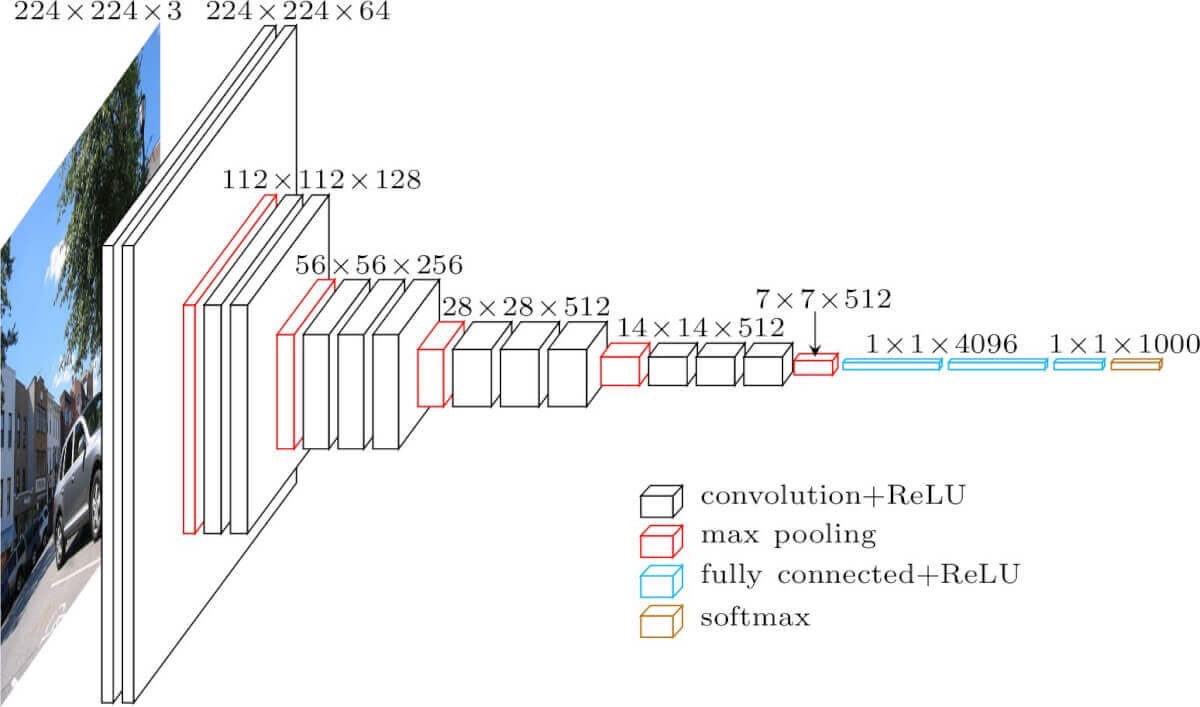

Обратим внимание на новую опцию сверточных слоев  - **Kernel_initializer**. В ней мы можем выбрать способ определения начальных значений весов слоя.

Чтобы нейросеть могла обучиться для решения определенной задачи, перед обучением нужно задать начальные значения весов, с которыми с одной стороны результат после прохождения входных данных по сети не будет стремиться к 0 или, наоборот, к бесконечно большому значению: в обоих случаях градиенты соответствующих весов будут либо исчезать (**vanishing**), то есть сеть не станет обучаться или, наоборот, скачкообразно увеличиваться (**exploding**), мешая весам сходиться к правильным значениям.

Можно задавать веса случайными числами из нормального или равномерного распределений, не зависящих от конфигурации нейросети.

В то же время [показано](https://https://arxiv.org/abs/1502.01852), что учитывание количества весов/размера слоев нейросети в параметрах случайных распределений позволяет лучше обучать нейросеть.

Одним из таких специальный распределений является **he_uniform** - веса выбираются случайным образом из равномерного распределения внутри диапазона $[-limit, limit]$, где $limit = \sqrt{\frac{6}{fan_{in}}}$, $fan_{in}$ - размер ядра в случае со сверточными слоями.

<table>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/1200px-Uniform_Distribution_PDF_SVG.svg.png" width="500">
</td>
<td>
<img src="https://wiki.analytica.com/images/4/4a/Normal%280%2C1%29.png" width="500">
</td>
</tr>
<tr>
<td>
Равномерное распределение
</td>
<td>
Нормальное распределение
</td>
</tr>
</table>

In [ ]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

#VGG1-блок
  # Начинаем со сверточных слоя, указывая тип активации на выходе из него,
  # способ заполнения краев (padding) и способ инициализации весов
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))

  # Слой dropout, который на каждом шаге "выключает" 20% случайно выбранных нейронов
  model.add(Dropout(0.2))

#VGG2-блок
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  # Знакомый нам softmax для выходного полносвязного слоя
  model.add(Dense(10, activation='softmax'))

  # Компилируем модель с функцией ошибки categorical crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='categorical_crossentropy',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])
  return model

In [ ]:
# При помощи функции define_model строим последовательную сверточную нейросеть
base_model = define_model()

При помощи `fit` натренируем $30$ эпох нашу модель с размером батча $128$.

На выходе мы получим натренированную модель и структуру данных типа словарь `history_cnn`, в котором в отдельных полях записана информация о ходе обучения модели

In [ ]:
history_cnn = base_model.fit(X_train, y_train,
              batch_size=128,
              epochs=30,
              validation_data=(X_test, y_test),
              shuffle=True)

In [ ]:
def plot_history(history_cnn):
  plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
  plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
  plt.xlabel('Количество эпох')
  plt.ylabel('Точность')
  plt.legend();

In [ ]:
# Построим графики точности на валидационной (val_acc) и трейновой (acc) выборках
# в конце каждой эпохи обучения
plot_history(history_cnn)

Точность на валидационной выборке (синяя линия) быстро сбавляет скорость роста и уступает точности на тренировочном датасете (оранжевая линия), так что мы немного переобучаемся, несмотря на слои **Dropout**.


Посмотрим на результаты классификации.

In [ ]:
# Выведем метрики качества нашей нейросети (функцию ошибки и точность)
# для тестовой выборки

base_model.evaluate(X_test, y_test)

## 2) Переобучение. Аугментация данных

Еще один способ решения проблемы переобучения сети —  аугментация ("дополнение") тренировочного датасета без привлечения реальных новых картинок.
 
Попробуем изменять наши исходные картинки перед тем, как они попадут в сетку при помощи различных трансформаций.

Конечно, можно было бы поштучно изменить каждую картинку, сохранить, как новый датасет и тренировать модель уже на нем.

Но это дает меньшую вариативность преобразований, занимает много места и памяти. Чтобы не изменять каждую картинку вручную, используют генераторы.

Создадим такой генератор на основе наших данных при помощи модуля из `keras` библиотеки `ImageDataGenerator`.

### 4. Генератор батчей с трансформацией

In [ ]:
# Импортируем нужный нам модель генератора
from keras.preprocessing.image import ImageDataGenerator

Создадим модуль ImageDataGenerator.

В качестве параметров укажем, какие изменения для картинок будем использовать.

В данном случае:

**width_shift_range**=0.1 - случайный сдвиг изображение по горизонтали на 0.1 ширины;

**height_shift_range**=0.1 - случайный сдвиг изображение по вертикали на 0.1 высоты;

**horizontal_flip**=True - случайно отражает картинку по горизонтали

Таким образом, мы увеличиваем наш датасет, давая нейросети большую вариативность входных данных.

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

Применим полученные трансформации к нашим исходным данным.


Обратите внимание, что размер батча **batch_size** нужно указать здесь, чтобы генератор знал, 
сколько картинок ему выдавать модели при обучении.

Теперь при обращении к `train_generator` мы сможем получать измененные изображения.

При помощи метода `flow` получим генератор, связанный с нашими данными

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=128)

`train_generator` является итератором, т.е., чтобы получить батч элементов
нужно выполнить какую-то итерирующую функцию: например, цикл `for`.

In [ ]:
for img in train_generator:
  img=img[0]
  break

In [ ]:
# Построим 8х8 трансформированных элементов нашего датасета
# при помощи функции plot_dataset_samples_grid

plot_dataset_samples_grid(img, dataset_name='transformed CIFAR10', N=8)

Вызовем функцию define_model, объявленную выше, которая создает модель нейросети из двух **VGG** блоков

In [ ]:
# Определим новую модель
gen_model = define_model()

In [ ]:
#  Обучим модель с данными из генератора при помощи .fit_generator,

# На выходе все так же мы получим натренированную модель и структуру history_cnn, 
# из которой можно достать значения функции ошибки и метрик качества на обеих выборках
history_cnn = gen_model.fit_generator(train_generator,
                        epochs=100,
                        validation_data=(X_test, y_test))

In [ ]:
# Посмотрим на изменение точности на валидационной (val_acc) и трейновой (acc) выборках
# с каждой эпохой
plot_history(history_cnn)


Видно, что точность на валидационной выборке еще не вышла на "плато", а модель не успела переобучиться, значит, при увеличении числа эпох тренировки мы сможем еще увеличить нашу точность на валидационном наборе данных.

Ай да аугментация!

In [ ]:
gen_model.evaluate(X_test, y_test)

In [ ]:

history_cnn = gen_model.fit_generator(train_generator,
                        epochs=100,
                        validation_data=(X_test, y_test))


In [ ]:
plot_history(history_cnn)

### Вывод

Аугментация тренировочной выборки положительно влияет на обобщающую способность сети, позволяя нейросети улавливать свойства целого класса, а не небольшой выборки тренировочных данных.

## 4) Cats vs Dogs



Теперь мы поработаем с датасетом, который не входит в набор стандартных датасетов библиотеки Keras, поэтому данные придется загружать из внешнего источника.

Загрузим датасет для бинарной классификации кошек и собак. Попробуем заставить нашу сеть ответить на вопрос: это кошки или собаки?




<table>
<tr>
<td>
<img src="https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a" width="200">
</td>
<td>
</td>
</tr>
<tr>
<td>
<img src="https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg" width="200">
</td>
<td>
<img src="https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg" width="200">
</td>
</tr>
</table>



In [ ]:
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
from keras.preprocessing.image import load_img, ImageDataGenerator

#### 1. Загрузка данных

In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

Теперь наши данные хранятся в папке `Cat_Dog_data` с разделением на поддиректории `train` и `test`.

Элементы каждого класса хранятся в своей директории (`cat` или `dog`). 

In [ ]:
base_dir = 'Cat_Dog_data'

train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

In [ ]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
plot_cats_dogs_samples(train_dir, N=4)

### 2. Подготовка данных 


Такой формат хранения удобен для использования функции генератора изображений `flow_from_directory`. 

Генератор не будет выкачивать все данные в оперативную память, а будет поочередно считывать из директорий нужные изображения и складывать их в батчи.

Создадим `ImageDataGenerator` для трейновой и тестовой выборок, поскольку обе выборки нужно доставать из директорий.

Укажем преобразование, нормализующее изображения 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Зададим поток тренировочных батчей из директории **train** и **test**;

Приведем все изображения к одному квадратному формату;

Укажем, что работаем с задачей бинарной классификации

In [ ]:
#Теперь для создания генератора вместо метода flow мы польщуемся 
# flow_from_directory

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(150, 150),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

In [ ]:
# Соотношение между номером класса и его называнием запишем в словарь
LABEL_DICT={1:'dog',0:'cat'}

In [ ]:
# train_generator является итератором, т.е., чтобы получить батч элементов
# нужно выполнить какую-то итерирующую функцию: например, цикл for
for img in train_generator:
  img=img[0]
  break

#Посмотрим, какие у нас вышли картинки при помощи функции plot_dataset_samples_grid
plot_dataset_samples_grid(img,'Cats vs Dogs', N=5)

### 3. Baseline
Для сравнения построим небольшую  baseline сверточную модель, состоящую из трех блоков **conv-maxpool** и пары полносвязных слоев.



Размер входящего изображения `input_shape`=($150$, $150$, $3$), активация последнего слоя - `sigmoid` вместо `softmax`, поскольку мы работаем со случаем бинарной классификации. На выходе мы получим вероятность от $0$ до $1$, что картинка принадлежит к классу $1$ (**dog**).


In [ ]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

#1й сверточный блок
  # Начинаем со сверточных слоя, указывая тип активации ReLU
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))

#2й сверточный блок
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

#3й сверточный блок
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(512, activation='relu'))
  # Sigmoid в качестве активации и одна выходная переменная - 
  # вероятность, что картинка принадлежит к классу 1
  model.add(Dense(1, activation='sigmoid'))


  # Компилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
  return model

In [ ]:
# Создаем новую модель
base_model = define_model()

In [ ]:
#Посмотрим, из чего наша модель состоит
base_model.summary()

In [ ]:
history = base_model.fit_generator(
      train_generator,
      epochs=7,
      validation_data=test_generator)

In [ ]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия) 
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
# Взглянем на итоговые результаты классификации на тестовой выборке 
# (функция ошибки, точность)
base_model.evaluate(test_generator)

Видно, что точность на тестовой выборке практически сразу вышла на плато около $0.8$, а точность на трейновой выборке почти достигла $1$, поэтому с такой моделью улучшить точность на новых данных уже вряд ли выйдет. 

Будем пробовать улучшать показатели радикальными способами, но сначала посмотрим, что эта сеть думает по поводу зоопарка из описания датасета.

### 4. Evaluation на особенных картинках

Посмотрим, что скажет нейросеть по поводу наших особенных картинок

In [ ]:
# Загрузим картинки из описания задачи при помощи функции load_special_images()
im1, im2, im3 = load_special_images()

Изменим размер картинок на размер входных данных нейросети ($150$х$150$).

Добавим дополнительную размерность, поскольку сеть принимает картинки с еще одной размерностью батча. 

Все это делаем при помощи функции `image_to_batch`

In [ ]:
im1_150 = image_to_batch(im1, 150)
im2_150 = image_to_batch(im2, 150)
im3_150 = image_to_batch(im3, 150)

In [ ]:
im1_150.shape

In [ ]:
im1_150.max()

Заметим, что прежде, чем подавать картинки в нейросеть их нужно не забыть **отнормировать**!

In [ ]:
im1_150 = im1_150/255.
im2_150 = im2_150/255.
im3_150 = im3_150/255.

Получим вероятности, что на картинках собаки, используя метод `predict`
нашей модели `base_model`

In [ ]:
pred1 = base_model.predict(im1_150)
pred2 = base_model.predict(im2_150)
pred3 = base_model.predict(im3_150)

In [ ]:
pred3

Посмотрим, для какой картинки какое предсказание дала нейросеть
при помощи функции `plot_special_images`

In [ ]:
plot_special_images(pred1,pred2,pred3)

## 5. Transfer learning

Использование предобученных моделей для новых задач

Как уже упоминалось ранее, есть архитектуры нейросетей, которые зарекомендовали себя в решении определенного класса задач, как, например, **VGG16**.

<img src="https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/download/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" width="700">


**VGG16** и подобные ей модели содержат большое количество параметров и обучение их с нуля может занять большое количество времени. 

Кроме того, бывают задачи, где данных изначально небольшое количество и даже аугментация не сильно спасает положение, тогда обучение сверточной сети может не быть очень успешным.

Поэтому можно использовать модель, которая уже была кем-то предобучена, загрузить ее веса и дообучать только последние слои, подстраивая их под свою конкретную задачу! 

#### План работы:

1.   Загрузить предобученную VGG16 модель без последних полносвязных слоев, отвечающих за конкретную задачу
2.   Построить свою полносвязную сеть для бинарной классификации кошек и собак
3.   Соединить две модели в одну!



### 1) Подготовим данные

Создадим `ImageDataGenerator` для трейновой и тестовой выборок,
указав преобразование, нормализующее изображения

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Изменим размеры картинок dataloader, поскольку модель **VGG16** принимает входные значения стандартизированного размера $224$х$224$x$3$.

Зададим поток тренировочных батчей из директории **train** и **test**.

Приведем все изображения к одному квадратному формату.

Укажем, что работаем с задачей бинарной классификации.

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(224, 224),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary')

### 2) Загрузим VGG16

В библиотеке `Keras` уже представлены архитектуры **State-of-the-art** моделей, поэтому можно достать **VGG16** модель одной строчкой кода.

In [ ]:
from keras.applications import vgg16 as vgg

Создадим **VGG** модель, в качестве параметра `weights` укажем `imagenet` - название
большого датасета с картинками, на котором сеть была натренирована;

`include_top` - False - не включать полносвязные слои вверху нейросети

In [ ]:
vgg_model = vgg.VGG16(weights='imagenet', 
                       include_top=False)

In [ ]:
#Посмотрим, из чего состоит VGG модель
vgg_model.summary()

Достанем последний слой `block5_pool` из **VGG** модели.

Сверху него мы далее построим наш классификатор.

In [ ]:
last = vgg_model.get_layer('block5_pool').output

### 3) Добавим небольшую нейросеть для бинарной классификации

In [ ]:
# Модуль, с помощью которого мы будем "сшивать" последовательные модели
from keras.engine import Model
# Импортируем Pooling по всему слою входных данных и нормализацию батчей
from keras.layers import GlobalAveragePooling2D, BatchNormalization

Добавим сверху слоя `last` **VGG** модели свои слои для классификации

In [ ]:
# Добавим новые GAP (вместо FLatten) и BatchNormalization слои
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)

# Привычные полносвязные слои
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

Объединим **VGG16** и **классификатор** в одного трансформера при помощи модуля `Model`

In [ ]:
fin_model = Model(vgg_model.input, pred)

Теперь самое важное: нам не нужно изменять и так хорошо натренированные веса
исходной модели, поэтому мы **"замораживаем"** их, при тренировке они будут использоваться
только для вычисления выходных данных

In [ ]:
for layer in vgg_model.layers:
     layer.trainable = False

In [ ]:
# Скомпилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
# (оптимизатор, который со стандартным набором параметров может обучить эффективную
# нейросеть), и метрикой - количеством правильно угаданных картинок.
fin_model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [ ]:
fin_model.summary()

In [ ]:
# Поставим модель обучаться 5 эпох при помощи модуля fit_generator
history_cnn = fin_model.fit_generator(train_generator,
              epochs=5,
              validation_data=test_generator,
              shuffle=True)

In [ ]:
plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
fin_model.evaluate(test_generator)

Использование предобученной модели **VGG** уже с 1й эпохи позволило нейросети достичь точности $>90$% на тестовой выборке!

Хотя и здесь изменение точности вышло на плато, текущий результат сильно превосходит бейзлайн и позволяет на его основе строить еще более мощные предсказательные модели.

### 4) Посмотрим результаты на особенных картинках

Изменим размер как у входных данных сети ($224х224$) и добавим дополнительную размерность при помощи функции `image_to_batch`

In [ ]:
im1_224=image_to_batch(im1,224)
im2_224=image_to_batch(im2,224)
im3_224=image_to_batch(im3,224)

Не забудем про нормировку!

In [ ]:
im1_224 = im1_224/255.
im2_224 = im2_224/255.
im3_224 = im2_224/255.

Получим вероятности, что на картинках собаки (используйте метод `predict`)


In [ ]:
pred1 = fin_model.predict(im1_224)
pred2 = fin_model.predict(im2_224)
pred3 = fin_model.predict(im3_224)

Посмотрим, для какой картинки какое предсказание дала нейросеть при помощи функции `plot_special_images`

In [ ]:
plot_special_images(pred1,pred2,pred3)

Как видно, несмотря на то, что нейросеть в целом хорошо "понимает" устройство основной выборки кошек и собак, особые случаи ей ясны уже не так хорошо. Хотя модель поняла, что в центре кошка, собаку с кошачьими глазами она перепутала с котом.

еше пример https://colab.research.google.com/drive/1XFJirVAEDPp7ful4Amn5EHqP7pRHo8Ff#scrollTo=oyDiY-xYoHnU